# **Importing Necessary Libiary**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Set the start method to 'spawn'
mp.set_start_method('spawn')

# **Loading Dataset**

In [ ]:
# Load the dataset
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.Resize((128, 128)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.ImageFolder(root='./../fer2013plus/fer2013/train', transform=transform)
testset = torchvision.datasets.ImageFolder(root='./../fer2013plus/fer2013/test', transform=transform)

# check data shape
from collections import Counter
# Count the number of samples per class in the training set
train_labels = [trainset[i][1] for i in range(len(trainset))]
train_counter = Counter(train_labels)

# Count the number of samples per class in the test set
test_labels = [testset[i][1] for i in range(len(testset))]
test_counter = Counter(test_labels)

class_names = trainset.classes
print(class_names)

# Print the distribution
print("Training set class distribution:")
for i, class_name in enumerate(class_names):
    print(f'{class_name:5s}: {train_counter[i]}')

print("\nTest set class distribution:")
for i, class_name in enumerate(class_names):
    print(f'{class_name:5s}: {test_counter[i]}')

total_samples = len(trainset)

# Calculate class weights based on the training set distribution
class_weights = {class_id: total_samples / count for class_id, count in train_counter.items()}
class_weights_list = [class_weights[label] for label in train_labels]
print(class_weights)
print(len(class_weights_list))

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(class_weights_list, len(class_weights_list), replacement=True, )

# Create data loaders
train_loader = DataLoader(trainset, batch_size=64, sampler=sampler)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Training set class distribution:
anger: 2466
contempt: 165
disgust: 191
fear : 652
happiness: 7528
neutral: 10308
sadness: 3514
surprise: 3562

Test set class distribution:
anger: 644
contempt: 51
disgust: 57
fear : 167
happiness: 1827
neutral: 2597
sadness: 856
surprise: 900
{0: 11.510948905109489, 1: 172.03636363636363, 2: 148.61780104712042, 3: 43.53680981595092, 4: 3.770722635494155, 5: 2.7537834691501746, 6: 8.077973819009676, 7: 7.969118472768108}
28386


# **VGG Model**

In [ ]:
# Define the model
# Dataset image size is 48x48 => 128x128

# Adding another convolutional layer block (total of 5 blocks)

class TinyVGG5(nn.Module):
    def __init__(self, num_classes):
        super(TinyVGG5, self).__init__()

        self.conv_layers = nn.Sequential(
            # Convolutional Layer Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 -> 64

            # Convolutional Layer Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 -> 32

            # Convolutional Layer Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 -> 16

            # Convolutional Layer Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 8

            # Convolutional Layer Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8 -> 4
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# **Loading State Dictionary**

In [ ]:
# Load the state dictionary
state_dict = torch.load('tiny_VGG.pth')

In [ ]:
# define train and validation as a funcnion

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    # Track metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg = running_loss / len(train_loader)
        train_losses.append(avg)
        train_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(running_loss / len(test_loader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch + 1}/{num_epochs}, train Loss: {train_losses[-1]:.4f}, train Acc: {train_accuracies[-1]:.2f}%, validation Loss: {val_losses[-1]:.4f}, validation Acc: {val_accuracies[-1]:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# plot training and validation loss
# Plotting the results
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, all_preds, all_labels):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trainset.classes)

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# **Hyperparameter Tuning**

## Freeze all layers except the final layer

In [ ]:
# Transfer Learning with Hyperparameter Tuning

param_grid = {
    'lr': [1e-4, 1e-5],
    'batch_size': [32, 64],
    'weight_decay': [1e-6, 1e-5, 1e-4]
}

best_params = None
best_val_accuracy = 0

for params in ParameterGrid(param_grid):
    print(params)
    # Initialize the model, criterion, and optimizer with the current hyperparameters
    model = TinyVGG5(num_classes=8).to(device)
    model.load_state_dict(state_dict, strict=False)
    optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = nn.CrossEntropyLoss()

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the final fully connected layer
    for param in model.fc_layers.parameters():
        param.requires_grad = True

    # Update data loaders with the current batch size
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], sampler=sampler)
    val_loader = torch.utils.data.DataLoader(testset, batch_size=params['batch_size'], shuffle=False)

    # Train the model
    _, _, _, val_accuracies, _, _ = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

    # Get the best validation accuracy for the current hyperparameters
    max_val_accuracy = max(val_accuracies)
    if max_val_accuracy > best_val_accuracy:
        best_val_accuracy = max_val_accuracy
        best_params = params

print(f'Best Hyperparameters: {best_params}')
print(f'Best Validation Accuracy: {best_val_accuracy}')

{'batch_size': 32, 'lr': 0.0001, 'weight_decay': 1e-06}
Epoch 1/15, train Loss: 0.0568, train Acc: 98.21%, validation Loss: 1.0427, validation Acc: 78.36%
Epoch 2/15, train Loss: 0.0511, train Acc: 98.37%, validation Loss: 1.1762, validation Acc: 78.48%
Epoch 3/15, train Loss: 0.0442, train Acc: 98.70%, validation Loss: 1.0974, validation Acc: 78.53%
Epoch 4/15, train Loss: 0.0367, train Acc: 98.86%, validation Loss: 1.0646, validation Acc: 78.70%
Epoch 5/15, train Loss: 0.0366, train Acc: 98.89%, validation Loss: 1.2659, validation Acc: 78.08%
Epoch 6/15, train Loss: 0.0333, train Acc: 98.89%, validation Loss: 1.2590, validation Acc: 77.93%
Epoch 7/15, train Loss: 0.0294, train Acc: 99.03%, validation Loss: 1.3024, validation Acc: 78.43%
Epoch 8/15, train Loss: 0.0300, train Acc: 99.01%, validation Loss: 1.2694, validation Acc: 78.43%
Epoch 9/15, train Loss: 0.0255, train Acc: 99.14%, validation Loss: 1.2619, validation Acc: 78.38%
Epoch 10/15, train Loss: 0.0291, train Acc: 99.04%, v

# **Train with best transfer learning setting**

Epoch 1/40, train Loss: 0.0472, train Acc: 98.49%, validation Loss: 1.0667, validation Acc: 78.45%
Epoch 2/40, train Loss: 0.0367, train Acc: 98.85%, validation Loss: 1.1149, validation Acc: 77.76%
Epoch 3/40, train Loss: 0.0313, train Acc: 99.06%, validation Loss: 1.0628, validation Acc: 78.39%
Epoch 4/40, train Loss: 0.0317, train Acc: 98.98%, validation Loss: 1.1472, validation Acc: 78.48%
Epoch 5/40, train Loss: 0.0244, train Acc: 99.25%, validation Loss: 1.2260, validation Acc: 77.88%
Epoch 6/40, train Loss: 0.0223, train Acc: 99.32%, validation Loss: 1.2386, validation Acc: 78.70%
Epoch 7/40, train Loss: 0.0225, train Acc: 99.26%, validation Loss: 1.2730, validation Acc: 78.64%
Epoch 8/40, train Loss: 0.0217, train Acc: 99.33%, validation Loss: 1.3190, validation Acc: 78.45%
Epoch 9/40, train Loss: 0.0188, train Acc: 99.39%, validation Loss: 1.3785, validation Acc: 78.87%
Epoch 10/40, train Loss: 0.0209, train Acc: 99.38%, validation Loss: 1.4646, validation Acc: 77.24%
Epoch 11/

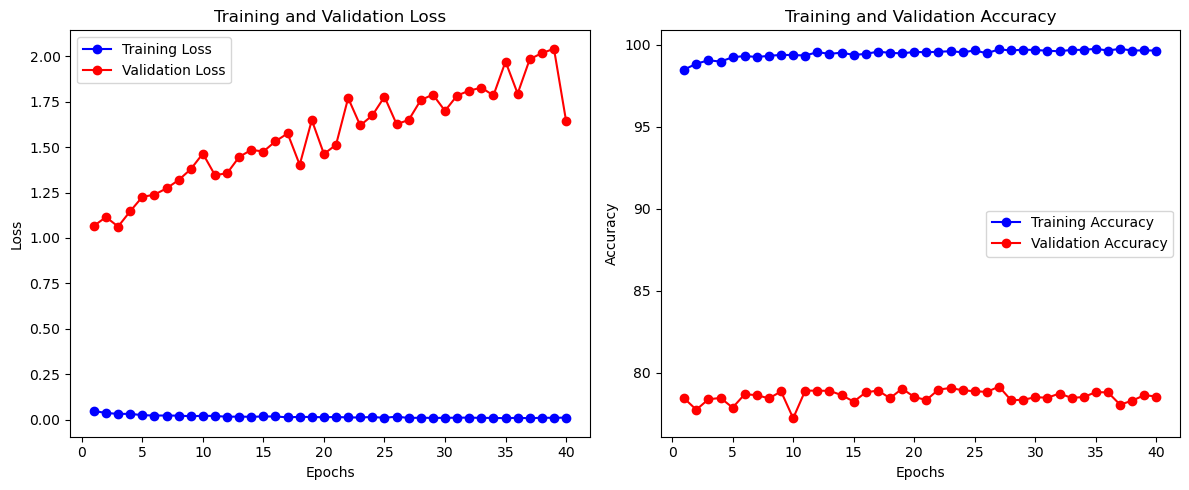

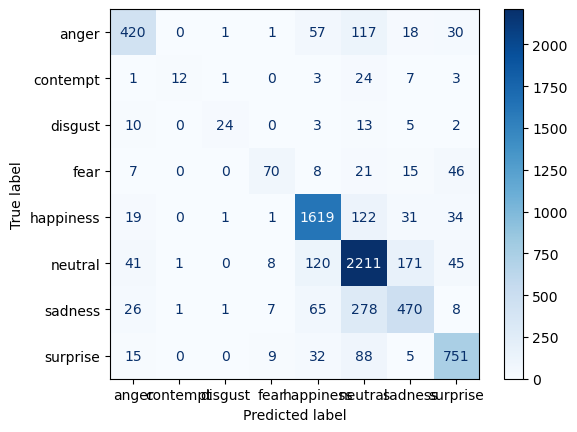

In [ ]:
model = TinyVGG5(num_classes=8).to(device)
model.load_state_dict(state_dict, strict=False)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in model.fc_layers.parameters():
    param.requires_grad = True

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=sampler)
val_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(model, train_loader, test_loader, criterion, optimizer, 40)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, 40, all_preds, all_labels)

# Evaluation

Accuracy of the network on the test images: 78.56%
Accuracy of anger: 65.22%
Accuracy of contempt: 23.53%
Accuracy of disgust: 42.11%
Accuracy of fear: 41.92%
Accuracy of happiness: 88.62%
Accuracy of neutral: 85.14%
Accuracy of sadness: 54.91%
Accuracy of surprise: 83.44%


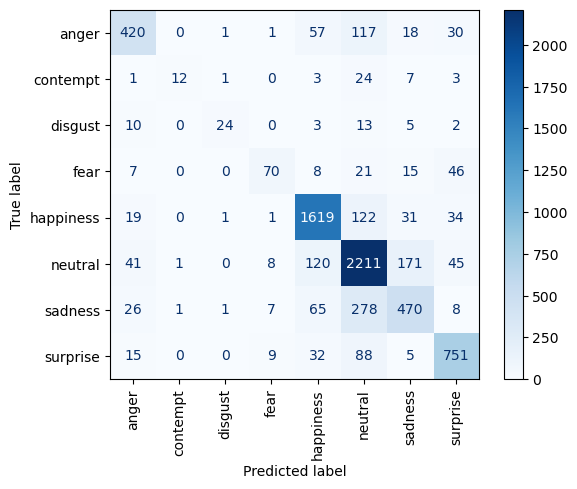

In [ ]:
correct = 0
total = 0

num_classes = 8
classes = trainset.classes

# Lists to store all labels and predictions for confusion matrix
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

# Test the model (accuracy per class)
class_correct = list(0. for _ in range(num_classes))
class_total = list(0. for _ in range(num_classes))

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(num_classes):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trainset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'tiny_VGG_transfer_learning.pth')